# Merging SRXs

In [16]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs
from ncbi_remap.prealn_wf import srr_per_srx, srx_reproducibility_score

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_merge_srr')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')

last updated: 2017-12-11 
Git hash: 9226a45f8c7528e964875f37bfe0e2441ad3d40e


In [2]:
# Constants

In the SRA, runs are considered technical replicates. However, we have found instances where users have uploaded different biological replicates or different samples as different SRRs within an SRX. Most useful analysis will be performed at the library (SRX) level, requiring SRRs to be merged. Instead of blindly merging SRRs, we want to verify that SRRs within an SRX behave like a technical replicate. Luckily the majority of SRXs in the SRA have only a single SRR, so this problem is somewhat limited.

## Number of SRRs Per SRX

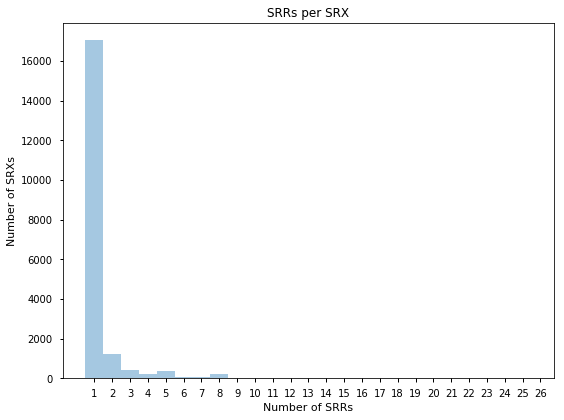

In [17]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('histogram_number_srr_per_srx'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = srr_per_srx(store).iloc[:, 0]
    bins = list(range(1, df.value_counts().index.max() + 1))
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df, bins=bins, ax=ax, kde=False, hist_kws={'align': 'left'})
    ax.set_title('SRRs per SRX')
    ax.set_ylabel('Number of SRXs')
    ax.set_xlabel('Number of SRRs')
    ax.set_xticks(bins)
    return fig

plot(store)

In [18]:
# Make Flags
srx_counts = srr_per_srx(store)
single_srr_srx = srx_counts[(srx_counts == 1)['srr']].index.tolist()
two_srr_srx = srx_counts[(srx_counts == 2)['srr']].index.tolist()
multi_srr_srx = srx_counts[(srx_counts > 2)['srr']].index.tolist()

# Table of counts
df_num_srr = srx_counts.srr.value_counts().apply(lambda x: '{:,}'.format(x)).to_frame()
df_num_srr.index.name = 'Number of SRR'
df_num_srr.columns=['Number SRXs']
df_num_srr

,Number SRXs
Number of SRR,
1,"17,072"
2,"1,216"
3,433
5,362
8,222
4,192
6,85
7,61
9,14


In [24]:
@memory.cache
def calc_corr(srxs, method='spearman', multi='pairwise', TH=1, show_warn=True):
    dfs = []
    for srx in srxs:
        dfs.extend(srx_reproducibility_score(store, srx, method=method, multi=multi, TH=TH, show_warn=show_warn))
        
    return pd.DataFrame(dfs, columns=['srx', 'srrs', 'corr'])

In [25]:
pairs = calc_corr(two_srr_srx, TH=1)

In [26]:
pairs.head()

,srx,srrs,corr
0,ERX1172351,ERR1092837:ERR1092838,0.991061
1,ERX1172352,ERR1092839:ERR1092840,0.991212
2,ERX1172353,ERR1092841:ERR1092842,0.991390
3,ERX1172354,ERR1092843:ERR1092844,0.990571
4,ERX1475762,ERR1404503:ERR1404560,0.956155


In [ ]:
pairs2 = calc_corr(two_srr_srx, method='sere', TH=1)

Automatic pdb calling has been turned ON


In [25]:
bad = ['SRX1892701', 'SRX1892702', 'SRX423326', 'SRX423475', 'SRX423855', 'SRX423874', 'SRX424394', 'SRX424397', 'SRX424398', 
       'SRX481228', 'SRX481229', 'SRX652595', 'SRX653818', 'SRX661845', 'SRX671605', 'SRX671607', 'SRX699105', 'SRX699106', 
       'SRX699107', 'SRX699108', 'SRX699109', 'SRX699110', 'SRX699111', 'SRX699112', 'SRX699113', 'SRX699114', 'SRX699115', 
       'SRX699116', 'SRX699117', 'SRX750068', 'SRX750069', 'SRX750071', 'SRX750072', 'SRX750073', 'SRX750074', 'SRX750075', 
       'SRX750076', 'SRX750077', 'SRX750078', 'SRX750079', 'SRX750080', 'SRX750081', 'SRX750082', 'SRX750083', 'SRX750084',
      ]

In [33]:
srx = bad[0]
store.select('prealn/complete', where='srx == SRX423326')

,srr,srx
958,SRR1104160,SRX423326
959,SRR1104161,SRX423326


In [37]:
store.select('prealn/workflow/feature_counts/counts', 'srx == SRX423326')

Series([], Name: count, dtype: int64)

In [134]:
store['prealn/workflow/fastq'].head()

,,md5_R1,libsize_R1,avgLen_R1,md5_R2,libsize_R2,avgLen_R2
srx,srr,,,,,,
SRX2581987,SRR5278103,1ef1ee5447afb2a8852f52224abf3940,17428278.0,142.974251,144600f42c19d3c2101b968d9f834567,17428278.0,143.68872
SRX2556775,SRR5251041,0d172b3db231285bf6c5ac22886655d6,2182591.0,151.000000,3217971c2b74f78d0043a7df05f5d93b,2182591.0,0.00000
SRX2556774,SRR5251040,8dc8b31af4c24a68aec57c474f6ce2fe,784813.0,151.000000,b663ee7b45f28f50a9c4061c63e88d8a,784813.0,0.00000
SRX2556773,SRR5251039,49c7e7a5e87a024e4a08e404b031b0a9,2864116.0,151.000000,8214f60218e85925f3b097b94d497b6e,2864116.0,0.00000
SRX2556772,SRR5251038,49182eff7bcd63740617729cf7c72e10,2565088.0,151.000000,e4cb3c308e2834b923a1f436e2c1c7d0,2565088.0,0.00000


In [135]:
store.root.prealn.workflow.fastq

/prealn/workflow/fastq (Group) ''
  children := ['table' (Table)]

In [85]:
store['test'] = ['bob']

TypeError: cannot properly create the storer for: [_TYPE_MAP] [group->/test (Group) '',value-><class 'list'>,format->fixed,append->False,kwargs->{'encoding': None}]

In [24]:
multis = calc_corr(multi_srr_srx, multi='m2')

2017-12-10 15:13:47,401 - WARNING - Missing Feature Counts: SRX015974


KeyboardInterrupt: 

In [7]:
# Remove SRX with out corrs
nona = df.dropna()

# Group by SRX and make lists for twos and multis
grps = nona.groupby('srx').srrs.count()
twos = nona.srx.isin(grps[grps == 1].index)
multi = nona.srx.isin(grps[grps > 1].index)

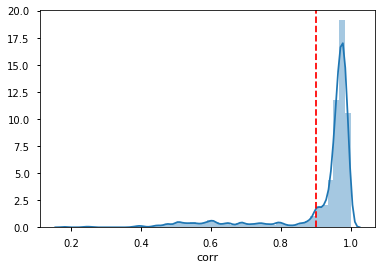

In [8]:
# plot twos
fig, ax = plt.subplots(1, 1)
sns.distplot(nona.loc[twos, 'corr'], ax=ax)
ax.axvline(0.90, ls='--', color='r')

In [9]:
((df.dropna().groupby('srx').min())['corr'] >= .90).sum()

1758

In [10]:
((df.dropna().groupby('srx').min())['corr'] < .90).sum()

249

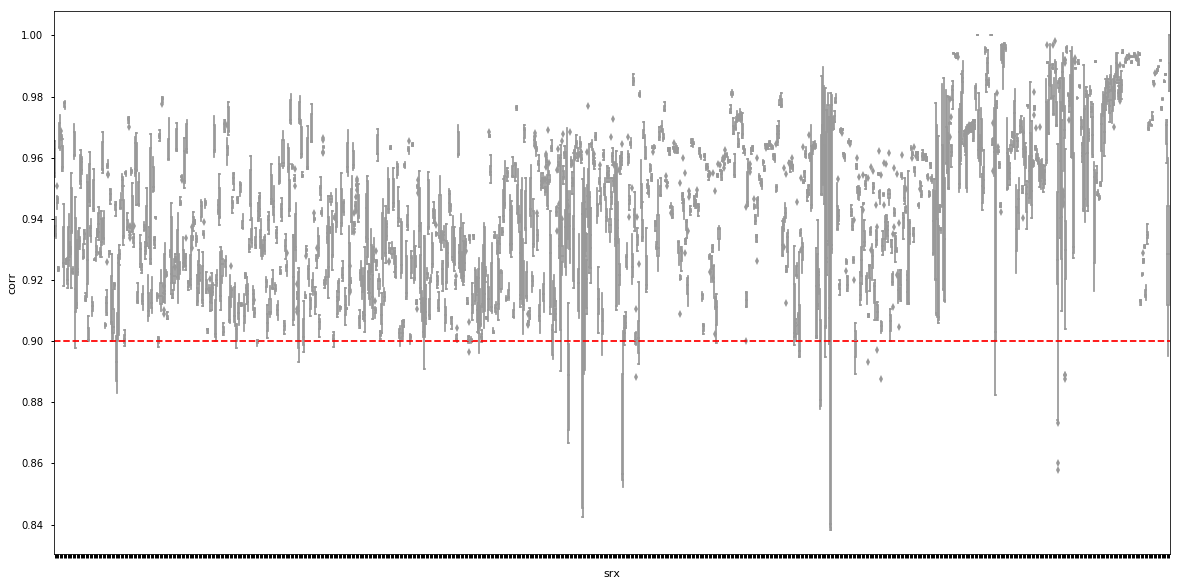

In [10]:
# Plot multis
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot('srx', 'corr', data=nona[multi], color='white', ax=ax)
ax.set_xticklabels([]);
ax.axhline(.90, ls='--', color='r')

## Mapping similarity among SRX

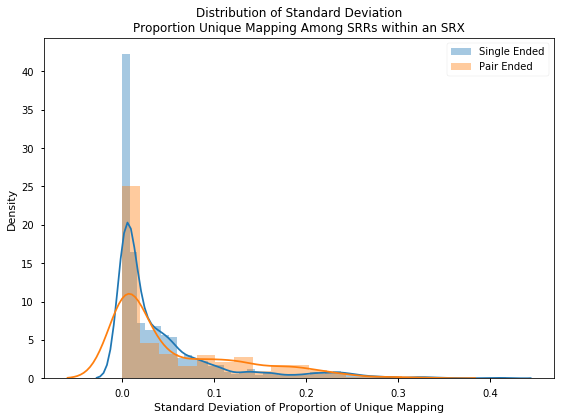

In [17]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('distplot_std_unique_mapping'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    from ncbi_remap.prealn_wf import srr_per_srx
    srx_counts = srr_per_srx(store)
    multi_srr_srx = srx_counts[(srx_counts > 1)['srr']].index.tolist()

    se = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_unpaired', 
                                          'num_uniquely_aligned']].copy()
    se.dropna(inplace=True)
    se.reset_index(inplace=True)
    se['prop_unique_aligned'] = se['num_uniquely_aligned'] / se['num_reads']
    se = se[se.srx.isin(multi_srr_srx)]

    pe = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_paired', 
                                             'num_concordant_reads_uniquely_aligned']].copy()
    pe.dropna(inplace=True)
    pe.reset_index(inplace=True)
    pe['prop_unique_aligned'] = pe['num_concordant_reads_uniquely_aligned'] / pe['num_reads']
    pe = pe[pe.srx.isin(multi_srr_srx)]

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Single Ended')
    sns.distplot(pe.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Pair Ended')
    ax.legend()
    
    ax.set_title('Distribution of Standard Deviation\nProportion Unique Mapping Among SRRs within an SRX')
    ax.set_xlabel('Standard Deviation of Proportion of Unique Mapping')
    ax.set_ylabel('Density');
    
    return fig

plot(store)